## Imports

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
from scipy.interpolate import griddata

import h5py
from scipy.integrate import quadrature
from scipy.stats import chi2
import pickle
import pandas as pd

from plots import scientific_format, dmu_idm_dr, plot_observations, plot_varied_recoupling
from data_generation.variables import *
from scipy.signal import argrelextrema
from scipy.stats import chisquare

import seaborn as sns

from observation_data.observations import *

from pathos.multiprocessing import ProcessingPool as Pool
import itertools
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')


/Users/nolansmyth/opt/anaconda3/envs/kinetic_recoupling/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# h5pydir = '/Users/nolansmyth/Dropbox/kinetic_recoupling/h5py_dat/'
h5pydir = 'h5py_dat/'

# h5pydir = '<YOUR PATH HERE>Dropbox/kinetic_recoupling/h5py_dat/'

In [10]:
plt.style.use("/Users/nolansmyth/Dropbox/kinetic_recoupling/figures/style.mplstyle")
sns.set_palette("colorblind")
# plt.style.use("<YOUR PATH HERE>Dropbox/kinetic_recoupling/figures/style.mplstyle")

In [11]:
pk_sd_interp = pickle.load(open("interps/pks_sd_interp.p", "rb"))
pk_dd_interp = pickle.load(open("interps/pks_dd_interp.p", "rb"))
pk_strong_interp = pickle.load(open("interps/pks_strong_interp.p", "rb"))
pk_strong_interp_late = pickle.load(open("interps/pks_strong_interp_late.p", "rb"))
best_fits_saved = np.load("./interps/best_fit_sds.npz")
best_a_dimless_arr = best_fits_saved["best_a_dimless_arr"]

pk_strong_interp_n2 = pickle.load(open("interps/pks_strong_interp_n2.p", "rb"))

In [12]:
#Get data for case with no recoupling
k = '1.0'
data_file=h5pydir+'class_testing_no_rec.hdf5'
with h5py.File(data_file, 'r') as f:
    tau_data = np.array(f['scalar']['k='+str(k)]['tau [Mpc]'])
    delta_chi_data = np.array(f['scalar']['k='+str(k)]['delta_idm_dr'])
    phi_data = np.array(f['scalar']['k='+str(k)]['phi'])
    theta_dr_data = np.array(f['scalar']['k='+str(k)]['theta_idr'])
    theta_data = np.array(f['scalar']['k='+str(k)]['theta_idm_dr'])
    
    
    delta_chi_no_rec = UnivariateSpline(tau_data, delta_chi_data, **spline_pars)
    delta_chi_dot_no_rec = delta_chi_no_rec.derivative()
    phi_no_rec = UnivariateSpline(tau_data, phi_data, **spline_pars)
    phi_dot_no_rec = phi_no_rec.derivative()
    theta_dr_no_rec = UnivariateSpline(tau_data, theta_dr_data, **spline_pars)

    theta_chi_no_rec = UnivariateSpline(tau_data, theta_data, **spline_pars)
    theta_chi_dot_no_rec = theta_chi_no_rec.derivative()

    Pks_no_rec = np.array(f['power_spectrum']['Pk'])
    kks_no_rec = np.array(f['power_spectrum']['kk'])

    kappa_dot_data_no_rec = np.flip(np.array(f['thermodynamics']['dmu_idm_dr']))
    z_data_no_rec = np.flip(np.array(f['thermodynamics']['z']))
    thermo_tau_data_no_rec = np.flip(np.array(f['thermodynamics']['conf. time [Mpc]']))

    rho_idr_no_rec = np.array(f['background']['(.)rho_idr'])
    rho_idm_no_rec = np.array(f['background']['(.)rho_idm_dr'])
    bkg_zs_no_rec = np.array(f['background']['z'])
    clTT_no_rec = np.array(f['cmb']['tt'])
    ll_no_rec = np.array(f['cmb']['ell'])

    thermo_taus_no_rec = UnivariateSpline(np.flip(z_data_no_rec), np.flip(thermo_tau_data_no_rec), **spline_pars)

    a_data = 1/(1+z_data_no_rec)
    a = UnivariateSpline(thermo_tau_data_no_rec, a_data, **spline_pars)
    aprime = a.derivative()
def conformal_H(z):
    return aprime(thermo_taus_no_rec(z))/a(thermo_taus_no_rec(z))

In [13]:
pk_no_rec_interp = interp1d(kks_no_rec, Pks_no_rec, kind='cubic', bounds_error=False, fill_value=0.0)

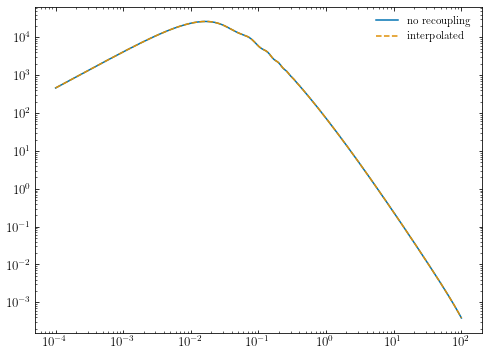

In [14]:
pks_no_rec = pk_no_rec_interp(kks_no_rec)
plt.loglog(kks_no_rec, Pks_no_rec, label='no recoupling')
plt.loglog(kks_no_rec, pks_no_rec, ls='--', label='interpolated')
plt.legend()
plt.show()


### Load Data

In [15]:
# Which A_recs to use for delta recoupling rate
A_recs = [1e11, 1e12, 1e14]
#wavenumber to use for delta recoupling rate
k = 10

# Get data for recouplings
Pk_arr = []
kappa_dot_taus_arr = []
kappa_dot_zs_arr = []
z_arr = []
tau_arr = []
thermo_tau_arr = []
rho_idr_arr = []
rho_idm_arr = []
a_prime_arr = []
a_arr = []

for A_rec in A_recs:
    data_file = h5pydir + "class_model_data_" + "%.2e" % A_rec + ".hdf5"

    with h5py.File(data_file, "r") as f:
        tau_data = np.array(f["scalar"]["k=" + str(k)]["tau [Mpc]"])
        delta_chi_data = np.array(f["scalar"]["k=" + str(k)]["delta_idm_dr"])
        phi_data = np.array(f["scalar"]["k=" + str(k)]["phi"])
        kappa_dot_data = np.flip(np.array(f["thermodynamics"]["dmu_idm_dr"]))
        z_data = np.flip(np.array(f["thermodynamics"]["z"]))
        thermo_tau_data = np.flip(np.array(f["thermodynamics"]["conf. time [Mpc]"]))
        cx2_data = np.flip(np.array(f["thermodynamics"]["c_idm_dr^2"]))
        theta_data = np.array(f["scalar"]["k=" + str(k)]["theta_idm_dr"])
        theta_dr_data = np.array(f["scalar"]["k=" + str(k)]["theta_idr"])
        psi_data = np.array(f["scalar"]["k=" + str(k)]["psi"])
        rho_idr_data = np.array(f["background"]["(.)rho_idr"])
        rho_idm_data = np.array(f["background"]["(.)rho_idm_dr"])
        bkg_tau_data = np.array(f["background"]["conf. time [Mpc]"])
        Pks = np.array(f["power_spectrum"]["Pk"])
        kks = np.array(f["power_spectrum"]["kk"])

    rho_idr = UnivariateSpline(bkg_tau_data, rho_idr_data, **spline_pars)
    rho_idm = UnivariateSpline(bkg_tau_data, rho_idm_data, **spline_pars)

    kappa_dot_taus = UnivariateSpline(thermo_tau_data, kappa_dot_data, **spline_pars)
    kappa_dot_zs = UnivariateSpline(
        np.flip(z_data), np.flip(kappa_dot_data), **spline_pars
    )
    thermo_taus = UnivariateSpline(
        np.flip(z_data), np.flip(thermo_tau_data), **spline_pars
    )

    a_data = 1 / (1 + z_data)
    a = UnivariateSpline(thermo_tau_data, a_data, **spline_pars)
    aprime = a.derivative()

    Pk_arr.append(Pks)
    kappa_dot_taus_arr.append(kappa_dot_taus)
    kappa_dot_zs_arr.append(kappa_dot_zs)
    z_arr.append(z_data)
    tau_arr.append(tau_data)
    thermo_tau_arr.append(thermo_taus)
    rho_idr_arr.append(rho_idr)
    rho_idm_arr.append(rho_idm)
    a_prime_arr.append(aprime)
    a_arr.append(a)

### Delta Recoupling Figures

In [16]:
def plot_delta_recoupling_rate():
    for i, A_rec in reversed(list(enumerate(A_recs))):
        plt.plot(
            tau_arr[i],
            4
            / 3
            * rho_idr_arr[i](tau_arr[i])
            / rho_idm_arr[i](tau_arr[i])
            * kappa_dot_taus_arr[i](tau_arr[i])
            / (a_prime_arr[i](tau_arr[i]) / a_arr[i](tau_arr[i])),
            label="A_rec = " + scientific_format(A_rec),
        )

    plt.plot([1e-3, 1e10], [1, 1], "k--")
    plt.plot([1e-3, 1e10], [1e-3, 1e-3], "k:")
    plt.plot([1e-3, 1e10], [1e3, 1e3], "k:")

    plt.xlim(2e-1, 2e-0)
    plt.ylim(1e-8, 1e8)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("$\\tau$ [Mpc]", fontsize=16)

    plt.ylabel("$\Gamma_{\mathrm{DM-DR}} / \mathcal{H}$", fontsize=16)
    plt.title("Comoving Scattering Rate")
    plt.legend()
    plot_dir = "Figures/"
    filename = "Scattering_rate_delta.pdf"
    # plt.savefig(plot_dir + filename)
    # plt.clf()
    plt.show()

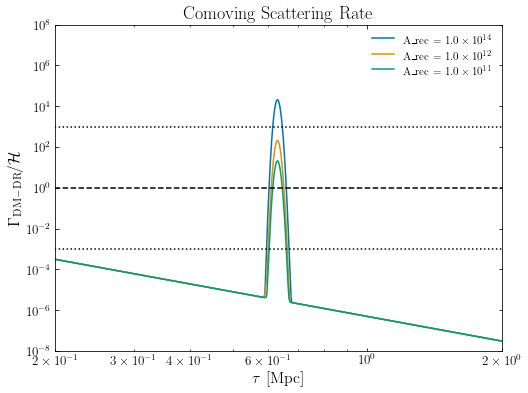

In [17]:
plot_delta_recoupling_rate()

In [18]:
def plot_delta_power_spectrum():
    lines = ["-", "--", "-."]
    for i, A_rec in reversed(list(enumerate(A_recs))):
        plt.plot(
            kk,
            Pk_arr[i] / Pks_no_rec,
            ls=lines[i % len(lines)],
            label="A_rec = " + scientific_format(A_rec),
        )

    plt.plot(kk, Pks_no_rec / Pks_no_rec, "--", label="No Rec")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("$k \mathrm{[h ~Mpc}^{-1}]$")
    plt.ylabel("$P(k)/P(k)_0$")
    plt.title("Matter Power Spectrum")
    plt.xlim(1, 1e2)
    plt.ylim(1e-3, 2)
    plt.legend()
    plot_dir = "Figures/"
    filename = "delta_power_spectrum.pdf"
    # plt.savefig(plot_dir + filename)
    # plt.clf()
    plt.show()

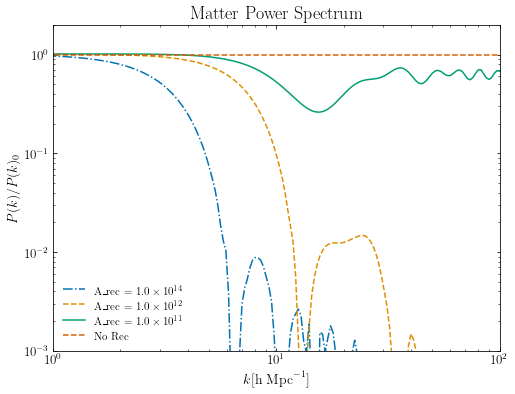

In [19]:
plot_delta_power_spectrum()

### Varied Recoupling Plots

In [20]:
def plot_varied_recoupling_strong(Tr0, Ar0, Tr1, Ar1, save=False):
    """
    Plot the interpolation between two scenarios with varied 
    recoupling temperature and/or strength (1,2).
    Normalized to the first scenario (0), presumably no recoupling.
    """

    zs = np.logspace(5, 8, 1000)
    dmus1 = [dmu_idm_dr(Tr1, Ar1, z) for z in zs]

    fig = plt.figure(1, figsize=(8, 8))
    plt.subplot(211)
    plt.plot(
        kk,
        # pk_strong_interp((Tr1, Ar1, kk)) / pk_dd_interp((Tr0, Ar0, kk)),
        pk_strong_interp_late((Tr1, Ar1, kk)) / pk_dd_interp((Tr0, Ar0, kk)),

        "b",
        label="$T_\mathrm{rec}$=%s eV, $A_\mathrm{rec}$=%s"
        % (scientific_format(Tr1 * ktoev), scientific_format(Ar1)),
    )
    
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(1e-1, 3e1)
    # plt.ylim(0.97, 1)
    plt.xlabel("k [h/Mpc]")
    plt.ylabel("$P(k)/P(k)_0$")
    plt.legend()
    plt.title("Double Decoupling")
    plt.subplot(212)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("z")
    plt.ylabel("$\Gamma_{\mathrm{DR-DM}}$")
    plt.plot(
        zs,
        dmus1,
        "b",
        label="$T_\mathrm{rec}$=%s eV, $A_\mathrm{rec}$=%s"
        % (scientific_format(Tr1 * ktoev), scientific_format(Ar1)),
    )
    
    plt.plot(np.logspace(5, 8, 100), 1e-3 * np.ones(100), "--k")
    plt.plot(np.logspace(5, 8, 100), np.ones(100), "--k")

    plt.xlim(zs[0], zs[-1])
    plt.ylim(1e-7, 1e7)

    plt.legend()
    fig.tight_layout(h_pad=2)

    if save:
        plot_dir = "Figures/"
        filename = "varying_recoupling_strong_{:.1e}{:.1e}{:.1e}{:.1e}.pdf".format(
            Tr1, Ar1
        )

        plt.savefig(plot_dir + filename)
        plt.clf()
    else:
        plt.show()


In [21]:
def dmu_idm_dr(
    T_rec,
    A_rec,
    z,
    case="recoupling",
    a_idm_dr=a_idm_dr,
    nindex_idm_dr=nindex_idm_dr,
    omega0_cdm=omega0_cdm,
    f_idm_dr=f_idm_dr,
    h=h,
    xi=xi_idr,
    ):
    """
    Calculate the comoving scattering rate for a given T_rec, A_rec, z.
    """
    base_rate = (
        a_idm_dr * ((1 + z) / (1e7)) ** nindex_idm_dr * omega0_cdm * f_idm_dr * h**2
    )
    T_idr = 2.7255 * xi

    # This is for a phase transition like scenario, not a delta function
    if case == "recoupling":
        if T_rec > T_idr * (1 + z):
            return base_rate * (1 + A_rec)

    return base_rate

def plot_varied_recoupling(Tr1, Tr2, Ar1, Ar2, num_interps=7, save=False):
    """
    Plot the interpolation between two scenarios with varied
    recoupling temperature and/or strength (1,2).
    Normalized to the first scenario (0), presumably no recoupling.
    """
    
    zs = np.logspace(5, 8, 1000)
    dmus1 = [dmu_idm_dr(Tr1, Ar1, z, a_idm_dr = 1e1, nindex_idm_dr=2) for z in zs]
    dmus2 = [dmu_idm_dr(Tr2, Ar2, z, a_idm_dr = 1e1, nindex_idm_dr=2) for z in zs]

    pks_no_rec

    fig = plt.figure(1, figsize=(8, 8))
    plt.subplot(211)
    plt.plot(
        kk,
        1 - (pk_strong_interp_n2((Tr1, Ar1, kk)) / Pks_no_rec),
        # "b",
        label="$T_\mathrm{rec}$=%s eV, $A_\mathrm{rec}$=%s"
        % (scientific_format(Tr1 * ktoev), scientific_format(Ar1)),
    )
    plt.plot(
        kk,
        1 - (pk_strong_interp_n2((Tr2, Ar2, kk)) / Pks_no_rec),
        # "r",
        label="$T_\mathrm{rec}$=%s eV, $A_\mathrm{rec}$=%s"
        % (scientific_format(Tr2 * ktoev), scientific_format(Ar2)),
    )
    
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(1e0, 1e2)
    # plt.ylim(0.97, 1)
    # plt.ylim(5e-4, 1e-1)
    plt.ylim(1e-1, 2e0)
    plt.xlabel("$k$ [$\mathrm{h}$ $\mathrm{Mpc}^{-1}$]")
    plt.ylabel("$1 - \Delta/\Delta_0$")
    # plt.ylabel("$\mathrm{Log}_{10}(1 - \Delta/\Delta_0)$")
    plt.legend(loc="upper left")
    # plt.title("Double Decoupling")
    plt.subplot(212)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("z")
    plt.ylabel("$\Gamma_{\mathrm{DR-DM}}$")
    plt.plot(
        zs,
        dmus1,
        # "b",
        label="$T_\mathrm{rec}$=%s eV, $A_\mathrm{rec}$=%s"
        % (scientific_format(Tr1 * ktoev), scientific_format(Ar1)),
    )
    plt.plot(
        zs,
        dmus2,
        # "r--",
        label="$T_\mathrm{rec}$=%s eV, $A_\mathrm{rec}$=%s"
        % (scientific_format(Tr2 * ktoev), scientific_format(Ar2)),
    )
    plt.plot(np.logspace(5, 8, 100), 1e-3 * np.ones(100), "--k")
    plt.plot(np.logspace(5, 8, 100), np.ones(100), "--k")

    plt.xlim(zs[0], zs[-1])
    # plt.ylim(1e-8, 2e3)

    plt.legend(loc="upper left")
    fig.tight_layout(h_pad=2)

    if save:
        plot_dir = "Figures/"
        filename = "varying_recoupling_{:.1e}{:.1e}{:.1e}{:.1e}.pdf".format(
            Tr1, Ar1, Tr2, Ar2
        )

        plt.savefig(plot_dir + filename)
        plt.clf()
    else:
        plt.show()

In [22]:
N_points = 100
T_rec_arr = np.logspace(5, 7, N_points)
# A_rec_strong_arr = np.logspace(-1, 8, N_points)
# A_rec_arr = np.logspace(-1, 3, N_points)
T_rec_strong_arr = np.logspace(4, 7, N_points)
A_rec_strong_arr = np.logspace(-1, 7, N_points)

Tr0 = T_rec_arr[0]
Ar0 = A_rec_strong_arr[0]

Showing interpolation between points with A_rec = 1.10e+03, T_rec = 3.27e+05 and A_rec = 2.15e+04, T_rec = 3.27e+05


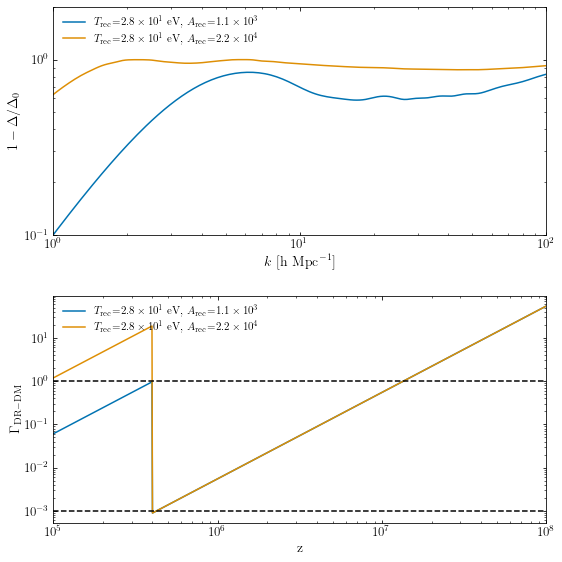

In [23]:
# # plot interpolation between two scenarios varying recoupling strength
idx = 50
idx_add = idx + 8
idx_add = idx + 16

print(
    "Showing interpolation between points with A_rec = %.2e, T_rec = %.2e and A_rec = %.2e, T_rec = %.2e"
    % (A_rec_strong_arr[idx], T_rec_strong_arr[idx], A_rec_strong_arr[idx_add], T_rec_strong_arr[idx])
)

# Varied Recoupling Strength Plot
plot_varied_recoupling(
    T_rec_strong_arr[idx],
    T_rec_strong_arr[idx],
    A_rec_strong_arr[idx],
    A_rec_strong_arr[idx_add],
)

Showing interpolation between points with A_rec = 4.33e+02, T_rec = 2.31e+05 and A_rec = 4.33e+02, T_rec = 4.04e+05


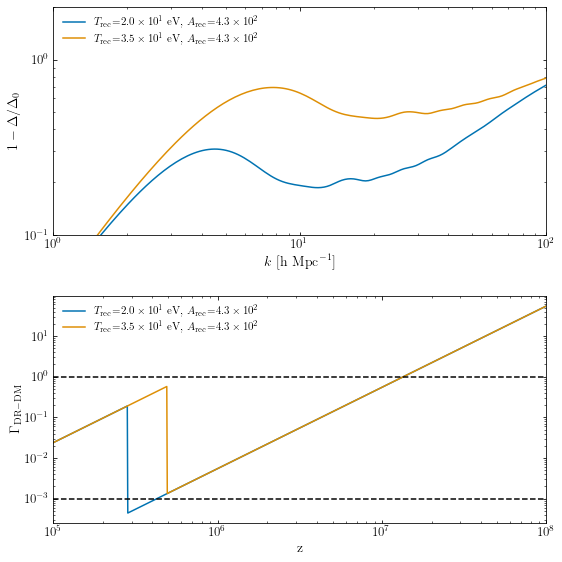

In [24]:
idx = 45
idx_add = idx + 8

print(
    "Showing interpolation between points with A_rec = %.2e, T_rec = %.2e and A_rec = %.2e, T_rec = %.2e"
    % (A_rec_strong_arr[idx], T_rec_strong_arr[idx], A_rec_strong_arr[idx], T_rec_strong_arr[idx_add])
)

# Varied Recoupling Temperature Plot
plot_varied_recoupling(
    T_rec_strong_arr[idx],
    T_rec_strong_arr[idx_add],
    A_rec_strong_arr[idx],
    A_rec_strong_arr[idx],
)

Showing interpolation between points with A_rec = 1.59e+03, T_rec = 3.76e+05 and A_rec = 6.37e+01, T_rec = 1.88e+06


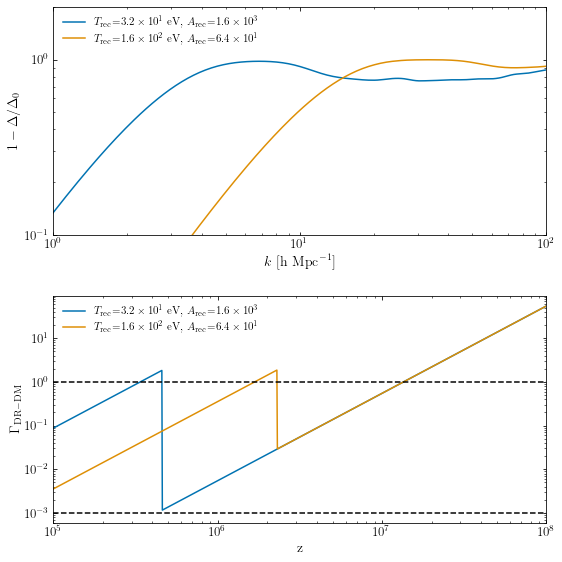

In [25]:
idx = 52

#Difference in temperature between case 1 and 2
fac = 5

T_1 = T_rec_strong_arr[idx]
T_2 = T_rec_strong_arr[idx] * fac
A_1 = A_rec_strong_arr[idx]
A_2 = A_rec_strong_arr[idx] * (1/fac)**2

print(
    "Showing interpolation between points with A_rec = %.2e, T_rec = %.2e and A_rec = %.2e, T_rec = %.2e"
    % (A_1, T_1, A_2, T_2)
)

# Same Peak $\Gamma_{\mathrm{DR-DM, peak}}$
plot_varied_recoupling(
    T_1,
    T_2,
    A_1,
    A_2,
)

### Phase transition matter power spectrum

In [26]:
def _plot_observations():

    plt.errorbar(
        dfPlanckTT["X"],
        dfPlanckTT["Y"] * (dfPlanckTT["X"]) ** 3 / (2 * np.pi**2),
        yerr=yerrTT_dimless,
        xerr=xerrTT,
        marker="o",
        ms=5,
        color="blue",
        ls="none",
        capsize=6,
        label="Planck TT",
    )

    plt.errorbar(
        dfPlanckEE["X"],
        dfPlanckEE["Y"] * (dfPlanckEE["X"]) ** 3 / (2 * np.pi**2),
        yerr=yerrEE_dimless,
        xerr=xerrEE,
        marker="o",
        ms=5,
        color="orange",
        ls="none",
        capsize=6,
        label="Planck EE",
    )

    plt.errorbar(
        dfPlanckPP["X"],
        dfPlanckPP["Y"] * (dfPlanckPP["X"]) ** 3 / (2 * np.pi**2),
        yerr=yerrPP_dimless,
        xerr=xerrPP,
        marker="o",
        ms=5,
        color="green",
        ls="none",
        capsize=6,
        label="Planck $\phi\phi$",
    )

    plt.errorbar(
        dfBOSS["X"],
        dfBOSS["Y"] * (dfBOSS["X"]) ** 3 / (2 * np.pi**2),
        yerr=yerrBOSSdimless,
        xerr=xerrBOSS,
        marker="o",
        ms=5,
        color="mediumpurple",
        ls="none",
        label=r"BOSS DR9 Ly-$\alpha$ forest",
    )

    plt.errorbar(
        dfDES["X"],
        dfDES["Y"] * (dfDES["X"] ** 3) / (2 * np.pi**2),
        yerr=yerrDESdimless,
        xerr=xerrDES,
        marker="o",
        ms=5,
        color="goldenrod",
        ls="none",
        capsize=6,
        label="DES Y1 cosmic Shear",
    )

    # No conversion because these are already dimensionless
    plt.errorbar(
        dfEDGES["X"],
        dfEDGES["Y"],
        xerr=xerrEDGES,
        yerr=yerrEDGES,
        marker="^",
        ms=10,
        color="r",
        ls="none",
        label=r"EDGES 21-cm proj.",
    )
    plt.errorbar(
        dfHERA["X"],
        dfHERA["Y"],
        xerr=xerrHERA,
        yerr=yerrHERA,
        marker="^",
        ms=10,
        color="teal",
        ls="none",
        label=r"HERA 21-cm proj.",
    )
    
def plot_observations(Tr, Ar, best_fit_a, mwarm = None, save=False):
    path = "observation_data/"

    if mwarm:

        mwarm_path = "output/warm" + mwarm + ".dat"

        try:
            dfWarm = pd.read_csv(
                mwarm_path,
                header=None,
                names=["k", "P(k)"],
                skiprows=4,
                delimiter="\s+",
            )
        except FileNotFoundError:
            print("ERROR: No file found for that warm dm mass")
            return

    plt.plot(
        dflcdm["k"],
        dflcdm["P(k)"] * (dflcdm["k"] ** 3) / (2 * np.pi**2),
        "k",
        label=r"$\Lambda_{CDM}$",
    )

    _plot_observations()

    plt.plot(
        kk,
        pk_strong_interp_n2((Tr, Ar, kk)) * (kk**3) / (2 * np.pi**2),
        "b",
        label="Kinetic Recoupling",
    )
    plt.plot(
        kk[-200:],
        pk_sd_interp((best_fit_a, kk[-200:])) * (kk[-200:] ** 3) / (2 * np.pi**2),
        "g-.",
        label="Single Decoupling",
    )

    # plt.plot(
    #     dfWarm["k"],
    #     dfWarm["P(k)"] * (dfWarm["k"] ** 3) / (2 * np.pi**2),
    #     "r--",
    #     label="Warm DM, m={} keV".format(mwarm.split("k")[0]),
    # )

    plt.xscale("log")
    plt.yscale("log")
    # plt.xlim(1, 100)
    # plt.ylim(2, 6e1)
    plt.xlim(1e-2, 1e2)
    plt.ylim(1e-4, 6e1)

    plt.xlabel("k [h/Mpc]")
    plt.ylabel("$\Delta^2_m(k)$")
    # plt.title("Dimensionless Power Spectrum")

    # plt.legend(loc="upper left")
    plt.legend()

    if save:
        plot_dir = "Figures/"
        filename = "Power_spectrum{:.1e}{:.1e}.pdf".format(Tr, Ar)
        plt.savefig(plot_dir + filename)
        plt.clf()
    # else:
    #     plt.show()

1.63e+05, 1.71e+02, 3.56e+02


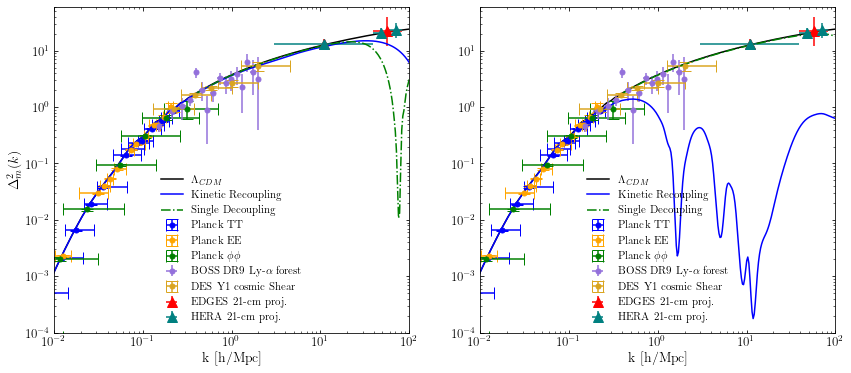

In [27]:
plot_idx = 40
plot_idx2 = 70


print(
    "{:.2e}, {:.2e}, {:.2e}".format(
        T_rec_strong_arr[plot_idx],
        A_rec_strong_arr[plot_idx],
        best_a_dimless_arr[plot_idx - 50, plot_idx - 50],
    )
)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)

plot_observations(
    T_rec_strong_arr[plot_idx],
    A_rec_strong_arr[plot_idx],
    best_a_dimless_arr[plot_idx - 50, plot_idx - 50],
    # mwarm="30kev",
    mwarm="50kev",
    save=False,
)

plt.subplot(1, 2, 2)

plot_observations(
    T_rec_strong_arr[plot_idx2],
    A_rec_strong_arr[plot_idx2],
    best_a_dimless_arr[plot_idx2 - 50, plot_idx2 - 50],
    mwarm="30kev",
    # mwarm="50kev",
    save=False,
)
plt.ylabel(None)

plt.show()

### Chi2 plots

In [28]:
#sort all relevant data by ks
constraint_ks = np.concatenate((dfDES["X"],dfBOSS["X"]))
constraint_pks = np.concatenate((dfDES["Y"], dfBOSS["Y"]))
constraint_pk_y_errs = np.concatenate((yerrDES, yerrBOSS), axis=1)
constraint_pk_x_errs = np.concatenate((xerrDES, xerrBOSS), axis=1)

constraint_ks_sorted = sorted(constraint_ks)
constraint_pks_sorted = [x for _, x in sorted(zip(constraint_ks, constraint_pks))]
constraint_pk_y_errs_sorted = np.zeros((2, len(constraint_ks)))
constraint_pk_y_errs_sorted[0] = np.array([x for _, x in sorted(zip(constraint_ks, constraint_pk_y_errs[0]))])
constraint_pk_y_errs_sorted[1] = np.array([x for _, x in sorted(zip(constraint_ks, constraint_pk_y_errs[1]))])
constraint_pk_y_var_sorted = np.zeros((2, len(constraint_ks)))
constraint_pk_y_var_sorted[0] = constraint_pk_y_errs_sorted[0]
constraint_pk_y_var_sorted[1] = constraint_pk_y_errs_sorted[1]


constraint_pk_x_errs_sorted = np.zeros((2, len(constraint_ks)))
constraint_pk_x_errs_sorted[0] = [x for _, x in sorted(zip(constraint_ks, constraint_pk_x_errs[0]))]
constraint_pk_x_errs_sorted[1] = [x for _, x in sorted(zip(constraint_ks, constraint_pk_x_errs[1]))]
constraint_pk_x_var_sorted = np.zeros((2, len(constraint_ks)))
constraint_pk_x_var_sorted[0] = constraint_pk_x_errs_sorted[0]
constraint_pk_x_var_sorted[1] = constraint_pk_x_errs_sorted[1]


### with edges + hera

constraint_ks_extended = np.concatenate((dfDES["X"], dfBOSS["X"], dfHERA["X"], dfEDGES["X"]))
# constraint_pks_extended = np.concatenate((dfDES["Y"], dfBOSS["Y"], dfHERA["Y"], dfEDGES["Y"]))
constraint_pks_extended = np.concatenate((dfDES["Y"], dfBOSS["Y"], HERA_y_dimfull, EDGES_y_dimfull))

constraint_pk_y_errs_extended = np.concatenate((yerrDES, yerrBOSS, yerrHERAdimfull, yerrEDGESdimfull), axis=1)
constraint_pk_x_errs_extended = np.concatenate((xerrDES, xerrBOSS, xerrHERA, xerrEDGES), axis=1)

constraint_ks_sorted_extended = sorted(constraint_ks_extended)
constraint_pks_sorted_extended = [x for _, x in sorted(zip(constraint_ks_extended, constraint_pks_extended))]
constraint_pk_y_errs_sorted_extended = np.zeros((2, len(constraint_ks_extended)))
constraint_pk_y_errs_sorted_extended[0] = np.array([x for _, x in sorted(zip(constraint_ks_extended, constraint_pk_y_errs_extended[0]))])
constraint_pk_y_errs_sorted_extended[1] = np.array([x for _, x in sorted(zip(constraint_ks_extended, constraint_pk_y_errs_extended[1]))])
constraint_pk_y_var_sorted_extended = np.zeros((2, len(constraint_ks_extended)))
constraint_pk_y_var_sorted_extended[0] = constraint_pk_y_errs_sorted_extended[0]
constraint_pk_y_var_sorted_extended[1] = constraint_pk_y_errs_sorted_extended[1]


constraint_pk_x_errs_sorted_extended = np.zeros((2, len(constraint_ks_extended)))
constraint_pk_x_errs_sorted_extended[0] = [x for _, x in sorted(zip(constraint_ks_extended, constraint_pk_x_errs_extended[0]))]
constraint_pk_x_errs_sorted_extended[1] = [x for _, x in sorted(zip(constraint_ks_extended, constraint_pk_x_errs_extended[1]))]
constraint_pk_x_var_sorted_extended = np.zeros((2, len(constraint_ks_extended)))
constraint_pk_x_var_sorted_extended[0] = constraint_pk_x_errs_sorted_extended[0]
constraint_pk_x_var_sorted_extended[1] = constraint_pk_x_errs_sorted_extended[1]


In [29]:
Tr1 = T_rec_strong_arr[50]
Ar1 = A_rec_strong_arr[90]
test_pks = np.zeros(len(constraint_ks_sorted))
test_pks_extended = np.zeros(len(constraint_ks_sorted_extended))
for i, k in enumerate(constraint_ks_sorted):
    # test_pks[i] = pk_strong_interp((Tr1, Ar1, k))
    # test_pks[i] = pk_strong_interp_late((Tr1, Ar1, k))
    test_pks[i] = pk_strong_interp_n2((Tr1, Ar1, k))
for i, k in enumerate(constraint_ks_sorted_extended):
    test_pks_extended[i] = pk_strong_interp_n2((Tr1, Ar1, k))

In [30]:
def make_constraint_plot(kcrit, crit_val=0.5):
    limit_grid = np.zeros((N_points, N_points))

    for i, Tr in enumerate(T_rec_strong_arr):
        for j, Ar in enumerate(A_rec_strong_arr):
            if (
                # pk_strong_interp((Tr, Ar, kcrit))
                pk_strong_interp_late((Tr, Ar, kcrit))

                / pk_dd_interp((Tr0, Ar0, kcrit))
                < crit_val
            ):
                limit_grid[i, j] = 1
                limit_grid[i, j] = 1
    return limit_grid

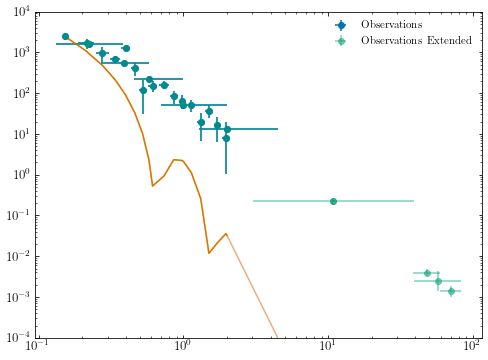

In [31]:
# plt.loglog(constraint_ks_sorted, constraint_pks_sorted, 'o')
plt.errorbar(constraint_ks_sorted, constraint_pks_sorted, yerr=constraint_pk_y_var_sorted, xerr=constraint_pk_x_var_sorted,fmt='o', label='Observations')
plt.loglog(constraint_ks_sorted, test_pks)

plt.errorbar(constraint_ks_sorted_extended, constraint_pks_sorted_extended, yerr=constraint_pk_y_var_sorted_extended, xerr=constraint_pk_x_var_sorted_extended,fmt='o', label='Observations Extended', alpha=0.5)
plt.loglog(constraint_ks_sorted_extended, test_pks_extended, alpha=0.5)

plt.legend()

plt.ylim(1e-4, 1e4)
plt.show()

In [32]:
#new chi2_statistic
interpolating_function = interp1d(constraint_ks_sorted, test_pks, kind='cubic')
y_interp = interpolating_function(constraint_ks_sorted)
dx = np.gradient(constraint_ks_sorted)
dy_dx = np.gradient(y_interp, dx)

y_total_err = np.sqrt(constraint_pk_y_var_sorted**2 + (dy_dx * constraint_pk_x_var_sorted)**2)
chi2_new = np.sum((constraint_pks_sorted - y_interp)**2 / y_total_err**2)
p_value = 1.0 - chi2.cdf(chi2_new, len(constraint_ks_sorted))

print("Chi2:  ", chi2_new)
print("P-value: ", p_value)
if p_value < 0.05:
    print("Model does not fit data")
else:
    print("Model fits data")

Chi2:   231.30273432019933
P-value:  0.0
Model does not fit data


In [33]:
def make_constraint_chisquare():
    chi2_grid = np.zeros((N_points, N_points))

    for i, Tr in enumerate(T_rec_strong_arr):
        for j, Ar in enumerate(A_rec_strong_arr):
            test_pks = np.array([pk_strong_interp_n2((Tr, Ar, k)) for k in constraint_ks_sorted])

            interpolating_function = interp1d(constraint_ks_sorted, test_pks, kind='cubic')
            y_interp = interpolating_function(constraint_ks_sorted)
            dx = np.gradient(constraint_ks_sorted)
            dy_dx = np.gradient(y_interp, dx)
            y_total_err = np.sqrt(constraint_pk_y_var_sorted**2 + (dy_dx * constraint_pk_x_var_sorted)**2)
            chi2 = np.sum((constraint_pks_sorted - y_interp)**2 / y_total_err**2)
            chi2_grid[i, j] = chi2
    return chi2_grid

def make_constraint_grid_chisquare(chi2_grid):
    #crit_val = 36.42 #for 24 points
    crit_val = chi2.isf(0.05, len(constraint_ks_sorted))
    limit_grid = np.zeros((N_points, N_points))
    for i in range(N_points):
        for j in range(N_points):
            if chi2_grid[i, j] > crit_val:
                limit_grid[i, j] = 1
    return limit_grid

def make_constraint_chisquare_extended():
    chi2_grid = np.zeros((N_points, N_points))

    for i, Tr in enumerate(T_rec_strong_arr):
        for j, Ar in enumerate(A_rec_strong_arr):
            test_pks_extended = np.array([pk_strong_interp_n2((Tr, Ar, k)) for k in constraint_ks_sorted_extended])
            interpolating_function = interp1d(constraint_ks_sorted_extended, test_pks_extended, kind='cubic')
            y_interp = interpolating_function(constraint_ks_sorted_extended)
            dx = np.gradient(constraint_ks_sorted_extended)
            dy_dx = np.gradient(y_interp, dx)
            y_total_err = np.sqrt(constraint_pk_y_var_sorted_extended**2 + (dy_dx * constraint_pk_x_var_sorted_extended)**2)
            chi2 = np.sum((constraint_pks_sorted_extended - y_interp)**2 / y_total_err**2)
            chi2_grid[i, j] = chi2
    return chi2_grid



In [35]:
chi2_grid = make_constraint_chisquare()

In [36]:
# limit_grid_chi2 = make_constraint_grid_chisquare(chi2_grid)

In [34]:
chi2_grid_extended = make_constraint_chisquare_extended()
# limit_grid_chi2_extended = make_constraint_grid_chisquare_extended(chi2_grid_extended)

In [53]:
chi2_grid

array([[ 18.83561638,  18.8356242 ,  18.83556941, ...,  74.31448333,
         84.19258797, 155.47962941],
       [ 18.83561637,  18.83562107,  18.83564421, ...,  82.17604219,
        130.3205753 , 164.09588677],
       [ 18.83570818,  18.83560986,  18.83560884, ...,  91.90746126,
        156.92213806, 170.9140522 ],
       ...,
       [ 18.83536669,  18.83524671,  18.83517432, ..., 350.91940413,
        358.88128235, 380.89866538],
       [ 18.83536671,  18.83524655,  18.83517517, ..., 350.91940413,
        358.88128236, 380.89866539],
       [ 18.83536639,  18.83524653,  18.8351746 , ..., 350.91940413,
        358.88128235, 380.89866537]])

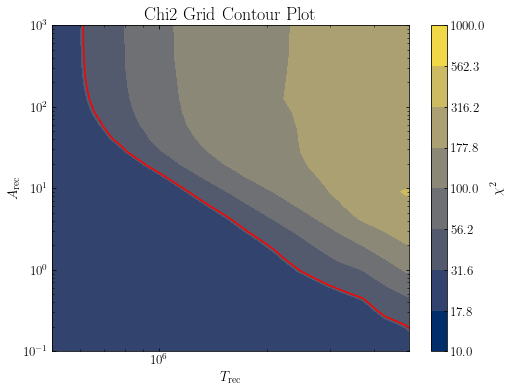

In [67]:
X, Y = np.meshgrid(T_rec_strong_arr, A_rec_strong_arr)

# Define the new grid
X_new = np.logspace(np.log10(X.min()), np.log10(X.max()), 50)  # 50 is the number of points for smoothing, adjust as needed
Y_new = np.logspace(np.log10(Y.min()), np.log10(Y.max()), 50)
X_new, Y_new = np.meshgrid(X_new, Y_new)

# Flatten your original data for the griddata function
points = np.array([X.flatten(), Y.flatten()]).T
values = chi2_grid.flatten()

# Perform the interpolation
chi2_grid_new = griddata(points, values, (X_new, Y_new), method='linear')

# Create the contour plot
plt.figure(figsize=(8, 6))
# plt.contourf(X_new, Y_new, chi2_grid_new, levels=np.logspace(np.log10(chi2_grid_new.min()),np.log10(chi2_grid_new.max()),7),norm=LogNorm(), cmap='cividis')
plt.contourf(X_new, Y_new, chi2_grid_new, levels=np.logspace(1,3,9),norm=LogNorm(), cmap='cividis')

cbar = plt.colorbar()
cbar.set_label(r'$\chi^2$')
plt.contour(X_new, Y_new, chi2_grid_new, levels=[chi2.isf(0.05, len(constraint_ks_sorted))], colors='red')

plt.xscale('log')
plt.yscale('log')
plt.xlim(5e5, 5e6)
plt.ylim(1e-1, 1e3)
plt.xlabel('$T_\mathrm{rec}$')
plt.ylabel('$A_\mathrm{rec}$')
plt.title('Chi2 Grid Contour Plot')
# plt.savefig('Figures/chi2_grid_contour_plot.pdf')
plt.show()

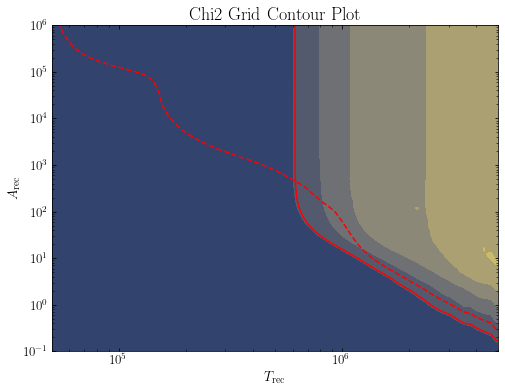

In [64]:
X, Y = np.meshgrid(T_rec_strong_arr, A_rec_strong_arr)

# Define the new grid
X_new = np.logspace(np.log10(X.min()), np.log10(X.max()), 100)  # 100 is the number of points for smoothing, adjust as needed
Y_new = np.logspace(np.log10(Y.min()), np.log10(Y.max()), 100)
X_new, Y_new = np.meshgrid(X_new, Y_new)

# Flatten your original data for the griddata function
points = np.array([X.flatten(), Y.flatten()]).T
values = chi2_grid.flatten()
values_extended = chi2_grid_extended.flatten()

# Perform the interpolation
chi2_grid_new = griddata(points, values, (X_new, Y_new), method='linear')
chi2_grid_new_extended = griddata(points, values_extended, (X_new, Y_new), method='linear')

# Create the contour plot
plt.figure(figsize=(8, 6))
plt.contourf(X_new, Y_new, chi2_grid_new, levels=np.logspace(np.log10(chi2_grid_new.min()),np.log10(chi2_grid_new.max()),7),norm=LogNorm(), cmap='cividis')
plt.contourf(X_new, Y_new, chi2_grid_new, levels=np.logspace(1,3,9),norm=LogNorm(), cmap='cividis')

# cbar = plt.colorbar()
# cbar.set_label(r'$\chi^2$')
plt.contour(X_new, Y_new, chi2_grid_new, levels=[chi2.isf(0.05, len(constraint_ks_sorted))], colors='red')
plt.contour(X_new, Y_new, chi2_grid_new_extended, levels=[chi2.isf(0.05, len(constraint_ks_sorted_extended))], colors='red', linestyles='dashed')

plt.xscale('log')
plt.yscale('log')
plt.xlim(5e4, 5e6)
plt.ylim(1e-1, 1e6)
plt.xlabel('$T_\mathrm{rec}$')
plt.ylabel('$A_\mathrm{rec}$')
plt.title('Chi2 Grid Contour Plot')
# plt.savefig('Figures/chi2_grid_contour_plot.pdf')
plt.show()

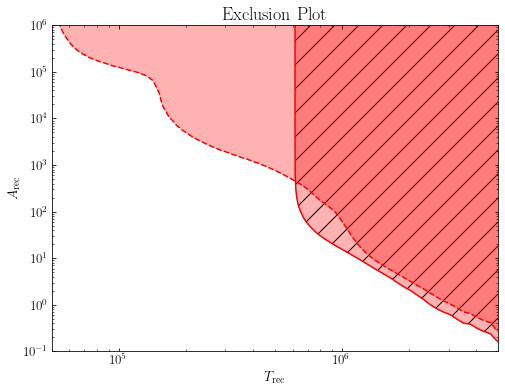

In [122]:
X, Y = np.meshgrid(T_rec_strong_arr, A_rec_strong_arr)

# Define the new grid
X_new = np.logspace(np.log10(X.min()), np.log10(X.max()), 100)  # 100 is the number of points for smoothing, adjust as needed
Y_new = np.logspace(np.log10(Y.min()), np.log10(Y.max()), 100)
X_new, Y_new = np.meshgrid(X_new, Y_new)

# Flatten your original data for the griddata function
points = np.array([X.flatten(), Y.flatten()]).T
values = chi2_grid.flatten()
values_extended = chi2_grid_extended.flatten()

# Perform the interpolation
chi2_grid_new = griddata(points, values, (X_new, Y_new), method='linear')
chi2_grid_new_extended = griddata(points, values_extended, (X_new, Y_new), method='linear')

# Create the contour plot
plt.figure(figsize=(8, 6))

# Define the levels for shading
level = chi2.isf(0.05, len(constraint_ks_sorted))
level_extended = chi2.isf(0.05, len(constraint_ks_sorted_extended))

# Create the contour plot with shading and hatching
plt.contour(X_new, Y_new, chi2_grid_new, levels=[level, np.inf], colors='red')
plt.contour(X_new, Y_new, chi2_grid_new_extended, levels=[level_extended, np.inf], colors='red', linestyles='dashed')

# Add shading and hatching patterns to the contour plots
plt.contourf(X_new, Y_new, chi2_grid_new, levels=[level, np.inf], colors='red', hatches=['/'], alpha=0.3)
plt.contourf(X_new, Y_new, chi2_grid_new_extended, levels=[level_extended, np.inf], colors='red', hatches=[''], alpha=0.3)

plt.xscale('log')
plt.yscale('log')
plt.xlim(5e4, 5e6)
plt.ylim(1e-1, 1e6)
plt.xlabel('$T_\mathrm{rec}$')
plt.ylabel('$A_\mathrm{rec}$')
plt.title('Exclusion Plot')
# plt.savefig('Figures/chi2_grid_contour_plot.pdf')
plt.show()